# Extracting direction from hidden layers
We search for directions corresponding to a concept in hidden layer activations.
We use several different methods:
* One Prompt
* Logistic Regression
* Principal Component Analysis (PCA)
* Class Means
* K-Means
* Random Direction as a baseline


In [1]:
import torch
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
from copy import deepcopy
import gc

In [2]:
my_path = "/data/ann_kathrin_dombrowski/ICE/ice_baseline/"

In [3]:
# import my modules
import sys
import importlib
import os

# Append the absolute path to sys.path
sys.path.append(os.path.join(my_path, 'modules'))
import wrapping
importlib.reload(wrapping)
from wrapping import WrappedModel


In [4]:
directions_dir = f'results/'
plots_dir = f'plots/'
data_dir = f'/data/ann_kathrin_dombrowski/ethics/utilitarianism/' # download from https://github.com/hendrycks/ethics

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


cuda


## Load Data

We show results on the utility dataset. You can download it from [here](https://people.eecs.berkeley.edu/~hendrycks/ethics.tar). Just copy the downloaded folder into the data folder.

In [5]:
def load_util_sentences(split="test"):
    data = pd.read_csv(data_dir + f'util_{split}.csv', header=None)
    sentences = []
    for d in data.iloc:
        sentences.append([d[0], d[1]])
    return np.array(sentences)



X_train = load_util_sentences(split='train')
X_test = load_util_sentences(split='test')
print(X_train.shape, X_test.shape)

# per default always the first sentence is the sentence with higher utility
# this function swaps the sentences with probability 0.5
def get_data(rng, data):
    m = len(data)
    labels = rng.integers(0, 2, size=m)
    data = data[np.arange(m), [1-labels, labels]].T
    return data, labels

rng = np.random.default_rng(0)
X_train, y_train = get_data(rng, X_train)
X_test, y_test = get_data(rng, X_test)


(13738, 2) (4808, 2)


### Example sentences
The label is one if the first sentence is more utilitarian than the second sentence and zero otherwise.

In [6]:
for i in range(5):
    print(f"sentence 1: {X_train[i, 0]}")
    print(f"sentence 2: {X_train[i, 1]}")
    print(f"  -> label: {y_train[i]}")


sentence 1: I built a sandcastle with my nephew. We made one small castle.
sentence 2: I built a sandcastle with my nephew
  -> label: 1
sentence 1: I forgot to wear my virus-proof mask when I visited the pet store.
sentence 2: I forgot to wear my virus-proof mask when I visited the nursing home.
  -> label: 1
sentence 1: I had to give a speech for class. My friends applauded for me.
sentence 2: I had to give a speech for class.
  -> label: 1
sentence 1: I cooked breakfast.  I threw it up after.
sentence 2: I cooked breakfast.
  -> label: 0
sentence 1: I go to buy a new saxophone from the instrument shop. Their are no saxophones left at the shop.
sentence 2: I go to buy a new saxophone from the instrument shop.
  -> label: 0


## Load Model

Use a huggingface [access token](https://huggingface.co/docs/hub/security-tokens) and load the Llama-2-7b-chat model.

In [7]:
# enter your authentication token from huggingface and press enter to access the models
auth_token = input()

In [ ]:
# load model
model_name = "Llama-2-7b-chat-hf"
model_path = f"meta-llama/{model_name}"
precision = torch.bfloat16
model = AutoModelForCausalLM.from_pretrained(model_path, use_auth_token=auth_token, device_map="auto").to(device=DEVICE, dtype=precision)
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_auth_token=auth_token, device_map="auto")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
num_layers = model.config.num_hidden_layers

## Get hidden activations
We use the custom WrappedModel class to get the internal activations. There are other ways to do this (for example with transformer lens or baukit).
We first add a prompt to each sentence to push the model into considering the concept that we aim to extract.
We then run each sentence through the model and save the hidden activations in each layer.
We get the outputs of the residual stream (the decoder block) per default.

In [ ]:
num_layers = model.config.num_hidden_layers
layer_ids = np.arange(0, num_layers) # which layers do we want to extract the hidden states from?

hidden_dim = model.config.hidden_size
block_name = "decoder_block" # should be one of ['self_attn', 'mlp', 'input_layernorm', 'post_attention_layernorm', 'decoder_block']
token_pos = -1 # at which token do we want to extract the hidden states? -1 means the last token.
batch_size = 64
# WRAP MODEL
# wrap the model in a class that allows to access the hidden states
wrapped_model = WrappedModel(model, tokenizer)
# make sure nothing is wrapped from previous runs
wrapped_model.unwrap()
# wrap the block you want to wrap
wrapped_model.wrap_block(layer_ids, block_name=block_name)

In [ ]:
format_prompt = 'Consider the amount of happiness in the following scenario:\n"{scenario}"\nThe amount of happiness in the scenario is '

In [ ]:
def batchify(lst, batch_size):
    """Yield successive batch_size chunks from lst."""
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

def calc_hidden_states(wrapped_model, sentences, format_prompt, batch_size=128, token_pos=-1):
    hidden_states = {}
    for sentence_batch in tqdm(batchify(sentences, batch_size), total=len(sentences)//batch_size):
        wrapped_model.reset()
        gc.collect()

        formatted_sentences = [format_prompt.format_map({'scenario': s}) for s in sentence_batch]        
        # get activations
        _ = wrapped_model.run_prompt(formatted_sentences)
        outputs = wrapped_model.get_activations(layer_ids, block_name=block_name, token_pos=token_pos).float().cpu().numpy()
        for key, values in outputs.items():
            # Check if the key already exists in dict1
            if key in hidden_states:
                # Concatenate the tensors along axis 0 and update dict1
                hidden_states[key] = np.concatenate((hidden_states[key], values), dim=0)
            else:
                # If the key doesn't exist in dict1, simply assign the tensor from dict2
                hidden_states[key] = values
    return hidden_states

In [ ]:
H0_train = calc_hidden_states(wrapped_model, X_train[:, 0], format_prompt, batch_size=batch_size, token_pos=token_pos)
H1_train = calc_hidden_states(wrapped_model, X_train[:, 1], format_prompt, batch_size=batch_size, token_pos=token_pos)
H0_test = calc_hidden_states(wrapped_model, X_test[:, 0], format_prompt, batch_size=batch_size, token_pos=token_pos)
H1_test = calc_hidden_states(wrapped_model, X_test[:, 1], format_prompt, batch_size=batch_size, token_pos=token_pos)

  0%|          | 0/214 [00:00<?, ?it/s]

215it [01:17,  2.78it/s]                         
215it [01:19,  2.72it/s]                         
76it [00:28,  2.68it/s]                        
76it [00:27,  2.79it/s]                        


In [ ]:
# convert to numpy arrays
H0_train = {key: value.float().cpu().numpy() for key, value in H0_train.items()}
H1_train = {key: value.float().cpu().numpy() for key, value in H1_train.items()}
H0_test = {key: value.float().cpu().numpy() for key, value in H0_test.items()}
H1_test = {key: value.float().cpu().numpy() for key, value in H1_test.items()}

AttributeError: 'numpy.ndarray' object has no attribute 'float'

We split the training set again, since we want an untouched part of the training set for our removal code.
For some methods we use the differences between contrastive pairs. We normalize all data.

In [34]:
n_dir_find = int(H0_train[0].shape[0]/2)
start_clf = n_dir_find
# n_dir_find = 2500

H0_train_s, H1_train_s, H_train_s, H_test = {}, {}, {}, {}
H0_train_clf, H1_train_clf, H_train_clf = {}, {}, {}
y_train_s = y_train[:n_dir_find]
y_train_clf = y_train[start_clf:]
for layer in H0_train.keys():
    H0_train_s[layer], H1_train_s[layer] = H0_train[layer][:n_dir_find], H1_train[layer][:n_dir_find]
    H_train_s[layer] = H0_train[layer][:n_dir_find]-H1_train[layer][:n_dir_find]
    H0_train_clf[layer], H1_train_clf[layer] = H0_train[layer][start_clf:], H1_train[layer][start_clf:]
    H_train_clf[layer] = H0_train[layer][start_clf:]-H1_train[layer][start_clf:]
    H_test[layer] = H0_test[layer]-H1_test[layer]

In [36]:
#normalizing data
scalers = {}
dscalers = {}
for layer in layer_ids:

    scaler = StandardScaler()
    scaler.fit(np.concatenate([H0_train_s[layer], H1_train_s[layer]], axis=0))
    scalers[layer] = scaler
    H0_train_s[layer] = scaler.transform(H0_train_s[layer])
    H1_train_s[layer] = scaler.transform(H1_train_s[layer])
    H0_train_clf[layer] = scaler.transform(H0_train_clf[layer])
    H1_train_clf[layer] = scaler.transform(H1_train_clf[layer])
    H0_test[layer] = scaler.transform(H0_test[layer])
    H1_test[layer] = scaler.transform(H1_test[layer])

    
    dscalers[layer] = StandardScaler()
    dscalers[layer].fit(H_train_s[layer])
    H_train_s[layer] = dscalers[layer].transform(H_train_s[layer])
    H_train_clf[layer] = dscalers[layer].transform(H_train_clf[layer])
    H_test[layer] = dscalers[layer].transform(H_test[layer])

## Direction Finding Methods

In [ ]:
directions = {}

In [45]:
# one prompt method

H0_prompt = calc_hidden_states(wrapped_model, ["Love"], format_prompt, batch_size=batch_size, token_pos=token_pos)
H1_prompt = calc_hidden_states(wrapped_model, ["Hate"], format_prompt, batch_size=batch_size, token_pos=token_pos)

directions["OnePrompt"] = {}

for layer in layer_ids:
    H0_prompt[layer] = scalers[layer].transform(H0_prompt[layer].float().cpu().numpy())
    H1_prompt[layer] = scalers[layer].transform(H1_prompt[layer].float().cpu().numpy())
    direction = H1_prompt[layer] - H0_prompt[layer]
    directions["OnePrompt"][layer] = direction

1it [00:00,  4.02it/s]
1it [00:00,  4.21it/s]


In [47]:
# random method
directions["Random"] = {}
num_random_directions = 10
for layer in layer_ids:
    direction = np.random.normal(0.0, 1.0, size=(num_random_directions, hidden_dim))
    for i in range(direction.shape[0]):
        Htr_i = np.dot(H_train_s[layer], direction[i].squeeze().T)
        lr = LogisticRegression(solver='liblinear').fit(Htr_i.reshape(-1, 1), y_train_s)
        coeff = np.sign(lr.coef_).squeeze()
        direction[i] = coeff*direction[i]
    directions["Random"][layer] = direction

In [48]:
# Logistic regression
directions["LogReg"] = {}
for layer in layer_ids:
    lr = LogisticRegression(solver='liblinear').fit(H_train_s[layer], y_train_s)
    coeff = np.sign(lr.coef_).squeeze()
    directions["LogReg"][layer] = coeff

In [ ]:
# Class means
directions["ClassMeans"] = {}
for layer in layer_ids:
    direction = np.expand_dims(H_train_s[layer][y_train_s==1].mean(axis=0), 0) - np.expand_dims(H_train_s[layer][y_train_s==0].mean(axis=0), 0)
    directions["ClassMeans"][layer] = direction

In [ ]:
# PCA on differences of contrastive pairs
directions["PCA_diffs"] = {}
for layer in layer_ids:
    pca = PCA(n_components=1, whiten=True).fit(H_train_s[layer])
    direction = pca.components_
    temp = pca.transform(H_train_s[layer])
    lr = LogisticRegression(solver='liblinear').fit(temp, y_train_s)
    coeff = np.sign(lr.coef_).squeeze()
    directions["PCA_diffs"][layer] = coeff*direction

In [ ]:
# PCA without taking differences
directions["PCA"] = {}
for layer in layer_ids:
    pca = PCA(n_components=1, whiten=True).fit(np.concatenate([H0_train_s[layer], H1_train_s[layer]], axis=0))
    direction = pca.components_
    temp = pca.transform(H_train_s[layer])
    lr = LogisticRegression(solver='liblinear').fit(temp, y_train_s)
    coeff = np.sign(lr.coef_).squeeze()
    directions["PCA"][layer] = coeff*direction

In [38]:
def scalar_projection(a1, a2):
    dot_product = np.dot(a1, a2.T)
    magnitude_a2_squared = np.dot(a2, a2.T)
    normed = dot_product / magnitude_a2_squared
    return normed
    
def get_vector_dir(method, model, H0_train, H1_train, H_train, y_train, dscalers, prompt_config=None, random_config=None):
    if method == 'Prompt' and prompt_config is not None:
        concept, counter = prompt_config['Concept'], prompt_config['Counter']
        s0, s1 = concept, counter
        for i in range(1, prompt_config['Repetitions']):
            s0 += f" {concept}"
            s1 += f" {counter}"
        X_prompt = np.array([[s0, s1]])
        H0_prompt, H1_prompt = create_dataset(X_prompt, 1, fmt_idx, node)

    Hn = []
    for layer in tqdm(range(num_layers)):
        # SUPERVISED
        if method == 'LogisticRegr':
            clf = LogisticRegression(C=1e-2, random_state=0).fit(H_train[layer], y_train)
            dir = clf.coef_.squeeze().reshape(1, -1)
            Hn.append(dir)
            
        if method == 'ClassMeans':
            dir = np.expand_dims(H_train[layer][y_train==1].mean(axis=0), 0) - np.expand_dims(H_train[layer][y_train==0].mean(axis=0), 0)
            Hn.append(dir)

        if method == 'PCA_diffs' and ice_config is not None:
            pca = PCA(n_components=1, whiten=True).fit(H_train[layer])
            dir = pca.components_
            temp = pca.transform(H_train[layer]).squeeze()
            lr = LogisticRegression(solver='liblinear').fit(temp.reshape(-1, 1), y_train)
            coeff = np.sign(lr.coef_).squeeze()
            Hn.append(coeff*dir)

        # UNSUPERVISED
        if method == 'PCA' and ice_config is not None:
            n_comps = ice_config['n_comps']
            org_data = np.concatenate([H0_train[layer], H1_train[layer]], axis=0)
            pca = PCA(n_components=n_comps, whiten=True).fit(org_data)
            dir = pca.components_.reshape(n_comps, -1)
            dir = dscalers[layer].transform(dir) #Scaling on the H0-H1 difference used in H_train is essential for unsupervised methods which are not learnt using H_train
            Htr_i = scalar_projection(H_train[layer], dir.squeeze())
            lr = LogisticRegression(solver='liblinear').fit(Htr_i.reshape(-1, 1), y_train)
            coeff = np.sign(lr.coef_).squeeze()
            Hn.append(coeff*dir)

        if method == 'K-means':
            # just use original data without taking ordered pairs
            org_data = np.concatenate([H0_train[layer], H1_train[layer]], axis=0) 
            kmeans = KMeans(n_clusters=2, n_init=5).fit(org_data)
            dir = (kmeans.cluster_centers_[0]-kmeans.cluster_centers_[1]).reshape(1, -1)
            dir = dscalers[layer].transform(dir)
            Htr_i = scalar_projection(H_train[layer], dir.squeeze())
            lr = LogisticRegression(solver='liblinear').fit(Htr_i.reshape(-1, 1), y_train)
            coeff = np.sign(lr.coef_).squeeze()
            Hn.append(coeff*dir)
            
        if method == 'Prompt' and prompt_config is not None:
            scaler = prompt_config['scalers'][layer]
            H0_prompt[layer] = scaler.transform(H0_prompt[layer])
            H1_prompt[layer] = scaler.transform(H1_prompt[layer])
            dir = H1_prompt[layer] - H0_prompt[layer]
            dir = dscalers[layer].transform(dir)
            Hn.append(dir)
            
        if method == 'Gaussian' and random_config is not None:
            dir = np.random.normal(0.0, 1.0, size=(random_config['Trials'], H0_train[layer].shape[1]))
            for i in range(dir.shape[0]):
                Htr_i = scalar_projection(H_train[layer], dir[i].squeeze())
                lr = LogisticRegression(solver='liblinear').fit(Htr_i.reshape(-1, 1), y_train)
                coeff = np.sign(lr.coef_).squeeze()
                dir[i] = coeff*dir[i]
            Hn.append(dir)
    
    return Hn

In [39]:
directions = {}

In [22]:
directions['PCA_diffs'] = get_vector_dir('PCA_diffs', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers = dscalers)

100%|██████████| 32/32 [00:41<00:00,  1.28s/it]


In [23]:
directions['PCA'] = get_vector_dir('PCA', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers = dscalers, ice_config=ice_config)

100%|██████████| 32/32 [01:14<00:00,  2.33s/it]


In [24]:
directions['K-means'] = get_vector_dir('K-means', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers=dscalers)

  0%|          | 0/32 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 32/32 [00:45<00:00,  1.43s/it]


In [25]:
directions['ClassMeans'] = get_vector_dir('ClassMeans', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers=dscalers)

100%|██████████| 32/32 [00:00<00:00, 73.20it/s]


In [26]:
OnePromptconfig = {'Concept' : 'Love', 'Counter' : 'Hate', 'Repetitions' : 1, 'scalers' : scalers}
directions['OnePrompt'] = get_vector_dir('Prompt', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers=dscalers, prompt_config=OnePromptconfig)

100%|██████████| 32/32 [00:00<00:00, 4506.52it/s]


In [27]:
OnePrompt5config = {'Concept' : 'Love', 'Counter' : 'Hate', 'Repetitions' : 5, 'scalers' : scalers}
directions['OnePrompt5'] = get_vector_dir('Prompt', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers=dscalers, prompt_config=OnePrompt5config)

100%|██████████| 32/32 [00:00<00:00, 4624.37it/s]


In [28]:
directions['LogisticRegr'] = get_vector_dir('LogisticRegr', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers = dscalers)

  0%|          | 0/32 [00:00<?, ?it/s]/data/ann_kathrin_dombrowski/miniconda3/envs/env_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  3%|▎         | 1/32 [00:02<01:02,  2.01s/it]/data/ann_kathrin_dombrowski/miniconda3/envs/env_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

In [29]:
random_config = {'Trials' : 10}
directions['Random'] = get_vector_dir('Gaussian', model, H0_train_s, H1_train_s, H_train_s, y_train_s, dscalers = dscalers, random_config=random_config)

100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


In [30]:
directions.keys()

dict_keys(['PCA_diffs', 'PCA', 'K-means', 'ClassMeans', 'OnePrompt', 'OnePrompt5', 'LogisticRegr', 'Random'])

In [31]:
fname = results_dir + 'utility_directions_{model_name}.pkl'
with open(fname, 'wb') as f:
    pickle.dump(directions, f, pickle.HIGHEST_PROTOCOL)

In [32]:
fname = results_dir + 'utility_directions_{model_name}.pkl'
with open(fname, 'rb') as f:
    directions = pickle.load(f)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
dfs = []
for layer in tqdm(range(num_layers)):
    temp = {key : directions[key][layer] for key in directions.keys()}
    temp['Random'] = np.expand_dims(temp['Random'][0], 0)
    for key in temp.keys():
        temp[key] = temp[key].squeeze()
    df = pd.DataFrame.from_dict(temp, orient='index')
    cosine_sim_matrix = cosine_similarity(df.values)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)
    dfs.append(cosine_sim_df)

 38%|███▊      | 12/32 [00:00<00:00, 22.75it/s]

100%|██████████| 32/32 [00:01<00:00, 20.96it/s]


<Axes: >

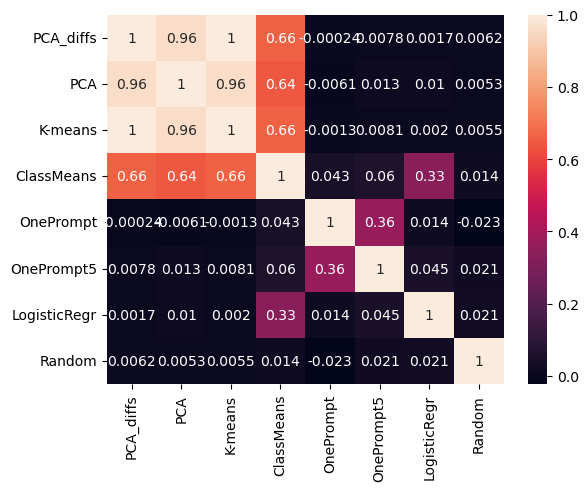

In [34]:
import seaborn as sns
sns.heatmap(dfs[10], annot=True)

PCA_diffs
PCA
K-means
ClassMeans
OnePrompt
LogisticRegr


100%|██████████| 32/32 [00:01<00:00, 23.38it/s]


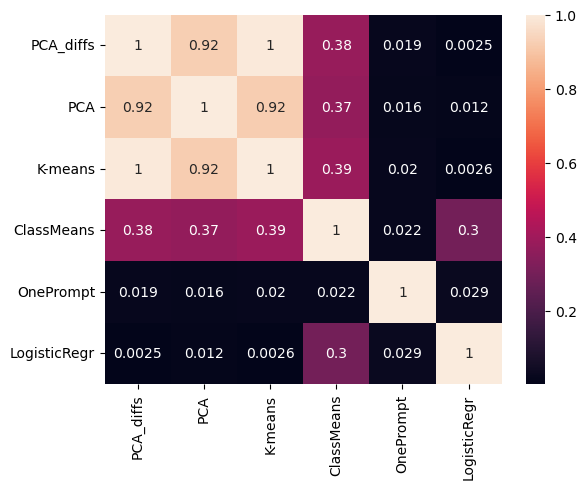

In [35]:
selected_keys = ['PCA_diffs', 'PCA', 'K-means', 'ClassMeans', 'OnePrompt', 'LogisticRegr']
new_dict = {}
for key in selected_keys:
    print(key)
    new_dict[key] = directions[key]

from sklearn.metrics.pairwise import cosine_similarity
dfs = []
for layer in tqdm(range(num_layers)):
    temp = {key : new_dict[key][layer] for key in new_dict.keys()}
    # temp['Random'] = np.expand_dims(temp['Random'][0], 0)
    for key in temp.keys():
        temp[key] = temp[key].squeeze()
    df = pd.DataFrame.from_dict(temp, orient='index')
    cosine_sim_matrix = cosine_similarity(df.values)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)
    dfs.append(cosine_sim_df)

import seaborn as sns
sns.heatmap(dfs[20], annot=True)
# save plot
plt.savefig(results_dir + f'utility_cossine_{model_name}_selection.pdf', dpi=300, bbox_inches='tight')

# Classification - Test for Correlation

In [36]:
def plot_hist(ax, v1, v2, title="", label1="train", label2="test"):
    # Generate list with the keys of the dictionary
    keys = list(v1.keys())
    v1 = np.array(list(v1.values()))[:,0]
    v2 = np.array(list(v2.values()))[:,0]

    bar_width = 0.25
    r1 = np.arange(len(v1))
    r2 = [x + bar_width for x in r1]
    ax.grid("on")

    # Create bars
    ax.bar(r1, v1, color='b', width=bar_width, edgecolor='grey', label=label1)
    ax.bar(r2, v2, color='g', width=bar_width, edgecolor='grey', label=label2)

    # Add xticks 
    ax.set_xlabel('layers')
    ax.set_ylabel('acc')
    ax.set_title(title)
    ax.set_axisbelow(True)

    # Set the x-ticks to be the keys from the dictionary
    ax.set_xticks([r + bar_width for r in range(len(v1))])
    ax.set_xticklabels(keys)
    
    ax.legend()

In [37]:
def calc_acc(H, y):
    len_H = H.shape[0]
    corr = ((H > 0) == y).sum()
    acc = corr/len_H
    # acc = max(acc, 1-acc)
    return acc

def classification(H_test, y_te, directions):
    test_acc_l = defaultdict(list)
    for layer in tqdm(range(num_layers)):
        Hte_i = scalar_projection(H_test[layer], directions[layer].squeeze())
        accte = calc_acc(Hte_i, y_te)
        test_acc_l[layer].append(accte)
    return test_acc_l

In [38]:
def clf_caller(method, H_train, H_test, y_tr, y_te, directions, train_acc, test_acc):
    if method == 'Random':
        trials = directions[0].shape[0]
        train_acc[method], test_acc[method] = defaultdict(list), defaultdict(list)
        tr_accs, te_accs = [], []
        for i in range(trials):
            temp = [directions[layer][i] for layer in range(num_layers)]
            acc_tr = classification(H_train, y_tr, temp)
            acc_te = classification(H_test, y_te, temp)
            tr_accs.append(acc_tr)
            te_accs.append(acc_te)
        for layer in range(model.config.num_hidden_layers):
            temptr = [tr_accs[i][layer][0] for i in range(trials)]
            tempte = [te_accs[i][layer][0] for i in range(trials)]
            train_acc[method][layer].append(sum(temptr)/len(temptr))
            test_acc[method][layer].append(sum(tempte)/len(tempte))
    
    else: 
        train_acc[method] = classification(H_train, y_tr, directions)
        test_acc[method] = classification(H_test, y_te, directions)
    # fig, axs = plt.subplots(1, 1, figsize=(8,6), sharey=False)
    # plot_hist(axs, train_acc[method], test_acc[method], title=method)
    return train_acc, test_acc

In [39]:
train_acc, test_acc = {}, {}

In [40]:
H_train_s[10].shape

(6869, 4096)

In [41]:
train_acc, test_acc = clf_caller('PCA_diffs', H_train, H_test, y_train, y_test, directions['PCA_diffs'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 255.49it/s]


In [42]:
train_acc, test_acc = clf_caller('PCA', H_train, H_test, y_train, y_test, directions['PCA'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 262.29it/s]


In [43]:
train_acc, test_acc = clf_caller('K-means', H_train, H_test, y_train, y_test, directions['K-means'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 265.60it/s]


In [44]:
train_acc, test_acc = clf_caller('ClassMeans', H_train, H_test, y_train, y_test, directions['ClassMeans'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 268.31it/s]


In [45]:
train_acc, test_acc = clf_caller('OnePrompt', H_train, H_test, y_train, y_test, directions['OnePrompt'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 280.03it/s]


In [46]:
train_acc, test_acc = clf_caller('OnePrompt5', H_train, H_test, y_train, y_test, directions['OnePrompt5'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 225.53it/s]


In [47]:
train_acc, test_acc = clf_caller('LogisticRegr', H_train, H_test, y_train, y_test, directions['LogisticRegr'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 50.22it/s]


In [48]:
train_acc, test_acc = clf_caller('Random', H_train, H_test, y_train, y_test, directions['Random'], train_acc, test_acc)

100%|██████████| 32/32 [00:00<00:00, 50.24it/s]


In [49]:
with open('trainaccs.pkl', 'wb') as f:
    pickle.dump(train_acc, f, pickle.HIGHEST_PROTOCOL)
with open('testaccs.pkl', 'wb') as f:
    pickle.dump(test_acc, f, pickle.HIGHEST_PROTOCOL)

In [50]:
def make_df(ddicts, names, layers=list(range(num_layers))):
    df = pd.DataFrame()
    df['layer'] = layers
    for i in range(len(ddicts)):
        ddict = ddicts[i]
        accs = [ddict[l][0] for l in layers]
        df[names[i]] = accs
    return df

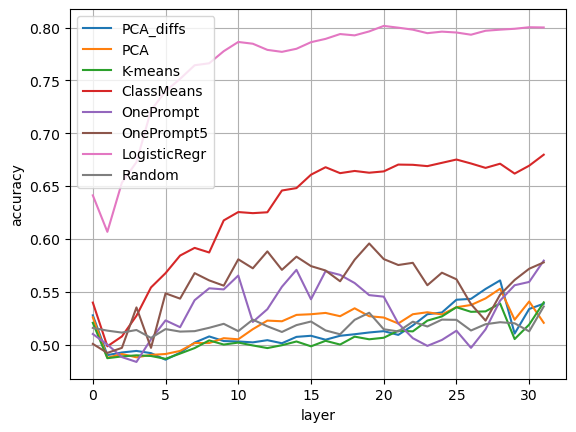

In [51]:
test_accs = list(test_acc.values())
supervised_names = list(test_acc.keys())
df = make_df(test_accs, supervised_names)
ax = df.plot(x='layer')
ax.set_ylabel('accuracy')
ax.grid(True)
plt.savefig(results_dir + f'baselines_utility_{model_name}.pdf', bbox_inches='tight')  # Change filename, dpi or other parameters as needed

PCA
K-means
ClassMeans
OnePrompt
LogisticRegr
Random


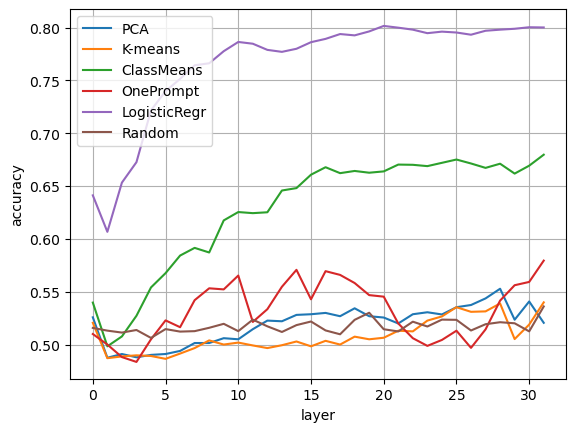

In [52]:
selected_keys = ['PCA', 'K-means', 'ClassMeans', 'OnePrompt', 'LogisticRegr', 'Random']


new_dict = {}
for key in selected_keys:
    print(key)
    new_dict[key] = test_acc[key]

test_accs = list(new_dict.values())
supervised_names = list(new_dict.keys())
df = make_df(test_accs, supervised_names)
ax = df.plot(x='layer')
ax.set_ylabel('accuracy')
ax.grid(True)
plt.savefig(results_dir + f'baselines_utility_{model_name}_selection.pdf', bbox_inches='tight')  # Change filename, dpi or other parameters as needed